## 1. Download and unzip dataset

In [1]:
!pip install google-auth google-auth-oauthlib google-auth-httplib2
!pip install google-api-python-client

In [2]:
# Authenticate with service account credentials
from google.oauth2 import service_account
from google.auth.transport.requests import Request
# Access Google Drive using the authenticated credentials
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload,MediaIoBaseDownload
import os
import io
from google_drive_utils import *
from helper_utils import *

In [3]:
drive_service = get_drive_service()
get_dataset_from_drive(drive_service)

fount dataset in drive
starting download...
Download 31.
Download 63.
Download 95.
Download 100.


In [4]:
!unzip apnea-ecg-database-1.0.0.zip -d apnea-ecg-database-1.0.0

Archive:  apnea-ecg-database-1.0.0.zip
replace apnea-ecg-database-1.0.0/x02.apn? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [5]:
!pip install wfdb

In [6]:
# import the WFDB package
import wfdb
import numpy as np
import scipy
from scipy.signal import butter, filtfilt, cheby1, freqz
import matplotlib.pyplot as plt

### Implementing chebychev bandpass filter

## 2. Signal Preprocessing Functions and Example

In [7]:
def chebyshev_filter(record):
  # Sampling parameters
  fs = 100  # Hz, as given in the dataset description

  # Desired filter parameters
  order = 5 # Polynomial order of the waveform (this current value is an estimation)
  Apass = 1.5  # dB, pass-band attuenation which I believe is max allowable amplitude
  fcut = 48    # Hz, cut-off frequency (research paper used 0.5 and 48 Hz)

  # Normalized frequency argument for cheby1
  wn = fcut / (0.5*fs) # Value to be within 0 and 1

  [b, a] = cheby1(order, Apass, wn)

  w, h = freqz(b, a, worN=8000)

  sos = cheby1(order, Apass, wn, output="sos")

  signal = record.p_signal
  # print(signal.shape)
  filtered_signal = scipy.signal.sosfilt(sos, signal)
  return filtered_signal

In [8]:
# demo the chebyshev filter
filename = 'apnea-ecg-database-1.0.0/a01'
single_segment = wfdb.rdrecord(filename)
annotation_small = wfdb.rdann(filename, extension="apn")

In [9]:
filtered_signal = chebyshev_filter(single_segment)

In [10]:
def create_spectrogram(signal, nfft = 128, sample_frequency = 100, noverlap = 16):
  signal_spectrogram,freq,t,im = plt.specgram(signal, Fs = sample_frequency, NFFT = nfft, noverlap=noverlap, cmap = 'jet_r')
  return signal_spectrogram,freq,t

/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


(129, 13200)
spectrogram avg value 0.0006377925572091166


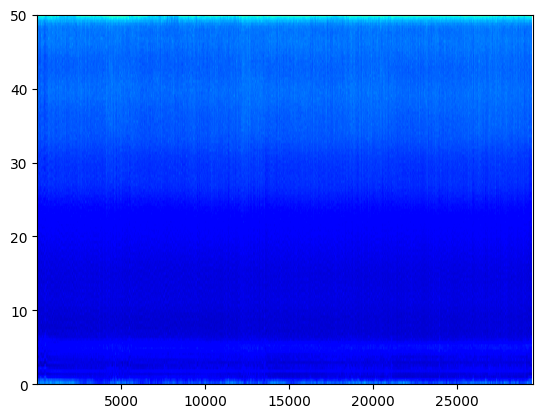

In [11]:
### Test creation of spectrogram
signal_spectrogram,freq,t  = create_spectrogram(np.array(filtered_signal).flatten(),
                                              nfft = 256,
                                              sample_frequency = 100, # set sample frequencey to be 100 as stated by the dataset
                                              noverlap = 32
                                              )
signal_spectrogram = np.array(signal_spectrogram)
print(signal_spectrogram.shape)
print('spectrogram avg value', np.mean(signal_spectrogram))

## 3. CNN LSTM Model And Dataset

In [12]:
import torchvision
from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import io
import torchvision
import torchvision.transforms as T
from torch.nn.utils.rnn import pad_sequence

### 3.1 Dataset

In [13]:
def get_spectrogram_and_annotations(file_path, fs = 100):
  """Split up spectrogram into segments of around 60s in length"""
  signal_record = wfdb.rdrecord(file_path)
  signal = wfdb.rdrecord(file_path).p_signal
  signal_length = len(signal)
  filtered_signal = chebyshev_filter(signal_record)
  filtered_signal = np.array(filtered_signal).flatten()
  spectrogram,freqs,times = create_spectrogram(filtered_signal)
  spectrogram_length = spectrogram.shape[1]
  annotations = [[t] for t in wfdb.rdann(file_path, extension = "apn").symbol]
  num_annotations = len(annotations)

  spectrogram_segment_width = np.max(np.where(times < 60))
  spectrogram_gap = spectrogram_length // num_annotations
  spectrogram_end = (signal_length / fs) // num_annotations * num_annotations
  segment_spectrograms = []
  segment_times = []

  time_gap = round(signal_length / fs / num_annotations,1)
  time_window_start = 0
  time_window_end = time_gap
  cur_time = 0
  segment_pointer = 0

  start_index = -1
  end_index = -1

  while time_window_end <= times[-1]:
    start_index = np.min(np.where(times >= time_window_start))
    end_index = np.min(np.where(times >= time_window_end))
    segment_spectrograms.append(spectrogram[:,start_index:end_index])
    segment_times.append(times[start_index:end_index])
    time_window_start+=time_gap
    time_window_end+=time_gap
  # print('time window',time_window_start,time_window_end)
  if len(segment_spectrograms) < num_annotations:
    start_index =  np.min(np.where(times >= time_window_start))
    segment_spectrograms.append(spectrogram[:,start_index:-1])
    segment_times.append(times[start_index:-1])
  correct_spectrogram_shape = segment_spectrograms[0].shape[1]
  print(f"number of spectrograms: {len(segment_spectrograms)}, number of annotations: {len(annotations)}")
  assert(len(segment_spectrograms) == len(annotations))
  # print('spectrogram shape',correct_spectrogram_shape)
  for i,spec in enumerate(segment_spectrograms):
    if abs(spec.shape[1] - correct_spectrogram_shape)>5:
      print('different spectrogram shape at index',i)
      print(i, spec.shape)
  correct_annotation_shape = len(annotations[0])
  # print('annotation shape',correct_annotation_shape)
  for i,ann in enumerate(annotations):
    if abs(len(ann) - correct_annotation_shape)>5:
      print('different annotation shape at index',i)
      print(i, len(ann))
    assert(len(ann) == correct_annotation_shape)
  return segment_spectrograms,annotations

In [14]:
# from https://www.kaggle.com/code/smjishanulislam/audio-mnist-with-pytorch
#option to resize for the PureCNN model
feature_transform_resize = T.Compose([
    T.ToPILImage(), # convert spectrogram to image
    T.Resize((100,100)),
    T.ToTensor() # convert to tensor
])
# keep size as is for CNN-LSTM and PureLSTM (uses padding) 
feature_transform = T.Compose([
    T.ToPILImage(), # convert spectrogram to image
    T.ToTensor() # convert to tensor
])

In [15]:
class SpectrogramDataset(Dataset):
  def __init__(self, file_paths = [], resize_spectrogram = True):
    super().__init__()
    self.spectrograms = []
    self.annotations = []
    self.resize_spectrogram = resize_spectrogram
    # add data from multiple files to this dataset
    for file_path in file_paths:
      segment_spectrograms, segment_annotations = get_spectrogram_and_annotations(file_path)
      self.spectrograms.extend(segment_spectrograms)
      self.annotations.extend(segment_annotations)
    self.spectrograms = [torch.from_numpy(spectrogram) for spectrogram in self.spectrograms]
        
  def __getitem__(self, idx):
    src = feature_transform_resize(self.spectrograms[idx]) * 10000 \
      if self.resize_spectrogram \
      else feature_transform(self.spectrograms[idx]) * 10000 
    trg = self.annotations[idx]
    if trg[0] == "N":
      trg[0] = 0
    elif trg[0] == "A":
      trg[0] = 1
    # print('trg', trg)
    return src, trg
  def __len__(self):
    return len(self.spectrograms)

In [16]:

dataset_path = "apnea-ecg-database-1.0.0"

train_file_names = sorted(list(set([filename[:3]
                      for dirname, _, filenames in os.walk(dataset_path)
                      for filename in filenames
                      if (filename.startswith("a")
                      or filename.startswith("b")
                      or filename.startswith("c"))
                      and len(filename) <= 7
                      and "apn" in str(filename)])))
test_file_names = sorted(list(set([filename[:3]
                      for dirname, _, filenames in os.walk(dataset_path)
                      for filename in filenames
                      if filename.startswith("x")
                      and len(filename) <= 7
                      and "apn" in str(filename)])))

# create file path list for dataset
train_file_paths = [os.path.join(dataset_path, file_name) for file_name in train_file_names]
test_file_paths = [os.path.join(dataset_path, file_name) for file_name in test_file_names]
print("===> distribution of annotations across files")
for filename in train_file_paths:
  annotation = wfdb.rdann(filename, extension="apn")
  # Find out which heading contains the labels
  annotation.get_label_fields()
  # Count number of Apnea-tagged intervals
  annotation.symbol.count("A")
  # The readings are labelled normal (N) or atrial premature contraction (A)
  # There should be 470 As and 19 Ns for "a01"
  print(filename)
  print(np.unique(annotation.symbol, return_counts=True))

===> distribution of annotations across files
apnea-ecg-database-1.0.0/a01
(array(['A', 'N'], dtype='<U1'), array([470,  19]))
apnea-ecg-database-1.0.0/a02
(array(['A', 'N'], dtype='<U1'), array([420, 108]))
apnea-ecg-database-1.0.0/a03
(array(['A', 'N'], dtype='<U1'), array([246, 273]))
apnea-ecg-database-1.0.0/a04
(array(['A', 'N'], dtype='<U1'), array([453,  39]))
apnea-ecg-database-1.0.0/a05
(array(['A', 'N'], dtype='<U1'), array([276, 178]))
apnea-ecg-database-1.0.0/a06
(array(['A', 'N'], dtype='<U1'), array([206, 304]))
apnea-ecg-database-1.0.0/a07
(array(['A', 'N'], dtype='<U1'), array([322, 189]))
apnea-ecg-database-1.0.0/a08
(array(['A', 'N'], dtype='<U1'), array([189, 312]))
apnea-ecg-database-1.0.0/a09
(array(['A', 'N'], dtype='<U1'), array([381, 114]))
apnea-ecg-database-1.0.0/a10
(array(['A', 'N'], dtype='<U1'), array([100, 417]))
apnea-ecg-database-1.0.0/a11
(array(['A', 'N'], dtype='<U1'), array([222, 244]))
apnea-ecg-database-1.0.0/a12
(array(['A', 'N'], dtype='<U1'), a

In [17]:
import os
def collate_fn(data):
  return data

initialising train dataset for 35 files


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 489, number of annotations: 489
different spectrogram shape at index 488
488 (65, 39)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 528, number of annotations: 528
different spectrogram shape at index 527
527 (65, 36)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 519, number of annotations: 519


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 492, number of annotations: 492
different spectrogram shape at index 491
491 (65, 39)
number of spectrograms: 454, number of annotations: 454


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 510, number of annotations: 510
different spectrogram shape at index 509
509 (65, 34)
number of spectrograms: 511, number of annotations: 511
number of spectrograms: 501, number of annotations: 501


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 495, number of annotations: 495
different spectrogram shape at index 494
494 (65, 36)
number of spectrograms: 517, number of annotations: 517
different spectrogram shape at index 516
516 (65, 47)
number of spectrograms: 466, number of annotations: 466
different spectrogram shape at index 465
465 (65, 35)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 577, number of annotations: 577
number of spectrograms: 495, number of annotations: 495


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 509, number of annotations: 509
different spectrogram shape at index 508
508 (65, 49)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 510, number of annotations: 510


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 482, number of annotations: 482


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 485, number of annotations: 485
different spectrogram shape at index 484
484 (65, 46)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 489, number of annotations: 489
different spectrogram shape at index 488
488 (65, 39)
number of spectrograms: 502, number of annotations: 502
number of spectrograms: 510, number of annotations: 510
number of spectrograms: 487, number of annotations: 487


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 517, number of annotations: 517
number of spectrograms: 441, number of annotations: 441


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 429, number of annotations: 429
different spectrogram shape at index 428
428 (65, 44)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 433, number of annotations: 433


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 484, number of annotations: 484


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 502, number of annotations: 502


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 454, number of annotations: 454


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 482, number of annotations: 482
number of spectrograms: 466, number of annotations: 466


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 468, number of annotations: 468


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 429, number of annotations: 429
different spectrogram shape at index 428
428 (65, 46)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 513, number of annotations: 513


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 468, number of annotations: 468


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 431, number of annotations: 431
different spectrogram shape at index 430
430 (65, 43)


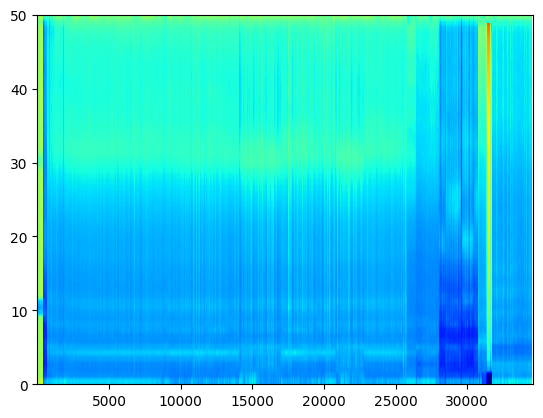

In [18]:

# list file names to be included in dataset
# train_file_names = ["a01","a02","a03","a04","a05","a06","a07","a08","a09","b01","b02","b03","b04","b05","c01","c02","c03","c04","c05","c06","c07","c08","c09"]
# create file path list for dataset
print(f'initialising train dataset for {len(train_file_names)} files')
train_file_paths = [os.path.join(dataset_path, file_name) for file_name in train_file_names]
train_dataset = SpectrogramDataset(train_file_paths, resize_spectrogram = False)


initialising train dataset for 35 files
number of spectrograms: 523, number of annotations: 523
different spectrogram shape at index 522
522 (65, 43)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 469, number of annotations: 469
number of spectrograms: 465, number of annotations: 465


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 482, number of annotations: 482
different spectrogram shape at index 481
481 (65, 43)
number of spectrograms: 505, number of annotations: 505


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 450, number of annotations: 450


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 509, number of annotations: 509
number of spectrograms: 517, number of annotations: 517


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 508, number of annotations: 508
different spectrogram shape at index 507
507 (65, 43)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 510, number of annotations: 510
different spectrogram shape at index 509
509 (65, 29)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 457, number of annotations: 457
different spectrogram shape at index 456
456 (65, 43)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 527, number of annotations: 527


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 506, number of annotations: 506
different spectrogram shape at index 505
505 (65, 33)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 490, number of annotations: 490


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 498, number of annotations: 498
different spectrogram shape at index 497
497 (65, 33)
number of spectrograms: 515, number of annotations: 515
different spectrogram shape at index 514
514 (65, 43)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 400, number of annotations: 400
different spectrogram shape at index 399
399 (65, 35)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 459, number of annotations: 459
different spectrogram shape at index 458
458 (65, 43)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 487, number of annotations: 487
different spectrogram shape at index 486
486 (65, 31)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 513, number of annotations: 513
number of spectrograms: 510, number of annotations: 510
different spectrogram shape at index 509
509 (65, 29)


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 482, number of annotations: 482


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 527, number of annotations: 527


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 429, number of annotations: 429
number of spectrograms: 510, number of annotations: 510


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 520, number of annotations: 520
different spectrogram shape at index 519
519 (65, 44)
number of spectrograms: 498, number of annotations: 498


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 495, number of annotations: 495


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 470, number of annotations: 470


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 511, number of annotations: 511


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 557, number of annotations: 557


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 538, number of annotations: 538
number of spectrograms: 473, number of annotations: 473
number of spectrograms: 475, number of annotations: 475


/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


number of spectrograms: 483, number of annotations: 483


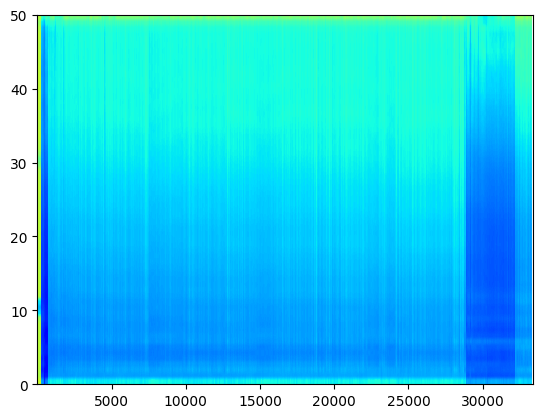

In [19]:
print(f'initialising train dataset for {len(test_file_names)} files')
test_file_paths = [os.path.join(dataset_path, file_name) for file_name in test_file_names]
test_dataset = SpectrogramDataset(test_file_paths, resize_spectrogram = False)


In [20]:
train_batch_size = 1
test_batch_size = 1
train_dl = DataLoader(
    train_dataset,
    batch_size = train_batch_size,
    shuffle = True,
    collate_fn = collate_fn,
    pin_memory = True
)
test_dl = DataLoader(
    test_dataset,
    batch_size = test_batch_size,
    shuffle = False,
    collate_fn = collate_fn,
    pin_memory = True
)

### 3.2 CNN-LSTM Model Definition

In [21]:
class CNN(nn.Module):
  def __init__(self,dropout = 0.2):
    super().__init__()
    self.cnn = nn.Sequential(
        # input size (batch_size, 1, 129, 48)
        nn.Conv2d(in_channels = 1, out_channels = 128, kernel_size = 2),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        # size(batch_size, 128, 128, 47)
        nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 2),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        # size(batch_size, 128, 127, 46)
        nn.MaxPool2d((2,2)),
        # size(batch_size, 128, 63, 23)
        nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 2),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        # size(batch_size, 128, 62, 22)
        nn.MaxPool2d((2,2)),
        # # size(batch_size, 128, 31, 11)
        nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 2),
        # nn.ReLU(),
        # size(batch_size, 128, 30, 10)
        nn.BatchNorm2d(128),
        
        nn.ReLU(),
    )
  def forward(self,src):
    out = self.cnn(src)
    return out

In [22]:
class LSTM(nn.Module):
  def __init__(self, input_dim = 32 * 7 * 7, hidden_dim = 512, num_layers = 1, dropout = 0.2):
    super().__init__()
    self.rnn = nn.LSTM(input_size = input_dim, hidden_size = hidden_dim, num_layers = num_layers, batch_first = False)
    self.dropout = nn.Dropout(dropout)
  def forward(self,src):
    # src = self.dropout(src)
    return self.rnn(src)

In [23]:
class Classifier(nn.Module):
  def __init__(self,input_dim = 512, dropout = 0.2):
    super().__init__()
    self.classifier = nn.Sequential(
        nn.Linear(input_dim, 1),
        nn.Sigmoid(),
    )
    self.dropout = nn.Dropout(dropout)
  def forward(self, src):
    out = self.classifier(src)
    return out

In [24]:
class CNN_LSTM(nn.Module):
  def __init__(self, dropout = 0.2):
    super().__init__()
    self.cnn = CNN(dropout)
    self.lstm = LSTM(input_dim = 1792, hidden_dim = 512, dropout = dropout, num_layers = 2)
    self.classifier = Classifier(input_dim = 512, dropout = dropout)
  def forward(self,src):
    src = self.cnn(src) # (b, c, h, w)
    b,c,h,w = src.shape
    src_sequence = src.reshape((w,b,c * h)).to(device)

    lstm_outs, (hidden,cell) = self.lstm(src_sequence) # ()

    out = self.classifier(lstm_outs[-1])
    return out

### 3.3 Model Initialisation

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
def get_model(pretrained_model_location = None):
    model = CNN_LSTM(dropout = 0.1)
    try:
        state_dict = torch.load(pretrained_model_location)
        model.load_state_dict(state_dict)
        model.to(device)
        print('found pretrained model')
    except:
        model.apply(init_weights)
        model.to(device)
        print("no pretrained model found...")
    return model

In [47]:

def train_CNN_LSTM(model, train_dl, print_interval = 5000):
  current_loss = 0
  current_accuracy = 0
  current_precision = 0
  current_recall = 0
  outputs_ls = []
  trgs_ls = []
  model.train()
  epoch_loss = 0
  epoch_output_ls = []
  epoch_trg_ls = []
  for i,data in enumerate(train_dl):
    optimizer.zero_grad()
    src = [_data[0] for _data in data]
    trg = [_data[1] for _data in data]
    src = torch.stack(src)
    b,c,h,w = src.shape
    src = src.to(device)
    trg = torch.tensor(trg)
    trg = trg.to(device)
    outputs = model(src)
    outputs = outputs.transpose(0,1)
    trg = trg.transpose(0,1)
    loss = criterion(outputs.float(),trg.float())
    current_loss += loss.item()
    epoch_loss += loss.item()
    loss.backward()
    optimizer.step()
    outputs,trg = outputs.view(-1),trg.view(-1)

    # outputs,trg = outputs.view(-1),trg.view(-1)
    epoch_output_ls.extend(outputs.tolist())
    epoch_trg_ls.extend(trg.tolist())
    outputs_ls.extend(outputs.tolist())
    trgs_ls.extend(trg.tolist())
    if i % print_interval == 0 and i > 0:
      current_accuracy = get_accuracy(outputs_ls, trgs_ls)
      precision = get_precision(outputs_ls, trgs_ls)
      recall = get_recall(outputs_ls, trgs_ls)
      current_precision = precision
      current_recall = recall
      print('iter',i * train_batch_size)
      print('outputs')
      print(outputs.tolist())
      print('trg')
      print(trg.tolist())
      print(f'avg accuracy over {print_interval} batches',current_accuracy)
      print(f'avg precision over {print_interval} batches',current_precision)
      print(f'avg recall over {print_interval} batches',current_recall)
      print(f'avg loss over {print_interval} batches',current_loss/print_interval)
      outputs_ls = []
      trgs_ls = []
      current_loss = 0
      current_accuracy = 0
      current_precision = 0
      current_recall = 0
  epoch_loss = epoch_loss/len(train_dl)
  epoch_accuracy = get_accuracy(epoch_output_ls,epoch_trg_ls)
  epoch_precision = get_precision(epoch_output_ls, epoch_trg_ls)
  epoch_recall = get_recall(epoch_output_ls, epoch_trg_ls)
  return {
      "epoch_loss":epoch_loss,
      "epoch_accuracy":epoch_accuracy,
      "epoch_precision":epoch_precision,
      "epoch_recall":epoch_recall
  }

In [48]:
def evaluate_CNN_LSTM(model, test_dl, print_interval = 5000):
  current_loss = 0
  current_accuracy = 0
  current_precision = 0
  current_recall = 0
  outputs_ls = []
  trgs_ls = []
  epoch_loss = 0
  epoch_output_ls = []
  epoch_trg_ls = []
  model.eval()
  with torch.no_grad():
    for i,data in enumerate(test_dl):
      src = [_data[0] for _data in data]
      trg = [_data[1] for _data in data]
      src = torch.stack(src)
      b,c,h,w = src.shape
      src = src.to(device)
      trg = torch.tensor(trg)
      trg = trg.to(device)
      outputs = model(src)
      outputs = outputs.transpose(0,1)
      trg = trg.transpose(0,1)
      loss = criterion(outputs.float(),trg.float())
      current_loss += loss.item()
      epoch_loss += loss.item()

      outputs,trg = outputs.view(-1),trg.view(-1)
      epoch_output_ls.extend(outputs.tolist())
      epoch_trg_ls.extend(trg.tolist())
      outputs_ls.extend(outputs.tolist())
      trgs_ls.extend(trg.tolist())
      if i % print_interval == 0:
        current_accuracy += get_accuracy(outputs_ls, trgs_ls)
        precision = get_precision(outputs_ls, trgs_ls)
        recall = get_recall(outputs_ls, trgs_ls)
        current_precision = precision
        current_recall = recall
        print('iter',i * test_batch_size)
        print(f'avg accuracy over {print_interval} batches',current_accuracy)
        print(f'avg precision over {print_interval} batches',current_precision)
        print(f'avg recall over {print_interval} batches',current_recall)
        print(f'avg loss over {print_interval} batches',current_loss/print_interval)
        outputs_ls = []
        trgs_ls = []
        current_loss = 0
        current_accuracy = 0
        current_precision = 0
        current_recall = 0
  epoch_loss = epoch_loss/len(test_dl)
  epoch_accuracy = get_accuracy(epoch_output_ls,epoch_trg_ls)
  epoch_precision = get_precision(epoch_output_ls, epoch_trg_ls)
  epoch_recall = get_recall(epoch_output_ls, epoch_trg_ls)
  return {
      "epoch_loss":epoch_loss,
      "epoch_accuracy":epoch_accuracy,
      "epoch_precision":epoch_precision,
      "epoch_recall":epoch_recall
  }

In [49]:
def train_eval_loop(model_name, model, train_func, test_func, train_dl, test_dl, start_epoch = 0, num_epochs = 5, save = True, state_dict_name = "", 
                    print_interval = 5000):
  metrics = {
      "model_name":model_name,
      "num_epochs":num_epochs,
      "train":[],
      "test":[]
  }
  for epoch in range(start_epoch,start_epoch + num_epochs):
    print(f"===> epoch: {epoch}")
    print("===> train metrics")
    train_metrics = train_func(model, train_dl, print_interval = print_interval)
    print(train_metrics)
    print("===> evaluate")
    test_metrics = test_func(model, test_dl, print_interval = print_interval)
    print(test_metrics)
    metrics["train"].append(train_metrics)
    metrics["test"].append(test_metrics)
    if save:
        save_state_dict(model, f"{state_dict_name}_{epoch}")
    #     upload_state_dict_to_drive(f"{state_dict_name}_{epoch}")
  return metrics
def eval_loop(model_name, model, test_func, test_dl, print_interval = 5000):
  print("===> evaluate")
  test_metrics = test_func(model, test_dl, print_interval = print_interval)
  print(test_metrics)
  return metrics

In [54]:
#replace with desired pretrained model
pretrained_model_path = "cnn_lstm_128_4__1792_512_2_epoch__9" # using pretrained V4 CNN-LSTM model by default,
                                                              # refer to report to see architecture
model = get_model(pretrained_model_path)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
model

found pretrained model


CNN_LSTM(
  (cnn): CNN(
    (cnn): Sequential(
      (0): Conv2d(1, 128, kernel_size=(2, 2), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU()
      (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
      (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): ReLU()
    )
  )
  (lstm): LSTM(
    (rnn): LSTM(1792, 512, num_layers=2)


In [55]:
from enum import Enum
class Models(Enum):
  CNN_LSTM = "CNN_LSTM"
  CNN_LSTM_With_Attention = "CNN_LSTM_With_Attention"
  PureCNN = "PureCNN"
  PureLSTM = "PureLSTM"

### 3.4 Eval Loop

In [56]:
eval_loop(Models.CNN_LSTM.value, model, evaluate_CNN_LSTM, test_dl)

===> evaluate
iter 0
avg accuracy over 5000 batches 1.0
avg precision over 5000 batches NA
avg recall over 5000 batches NA
avg loss over 5000 batches 0.0001225396752357483
iter 5000
avg accuracy over 5000 batches 0.7274
avg precision over 5000 batches 0.6112426035502958
avg recall over 5000 batches 0.59401955146636
avg loss over 5000 batches 0.8085300979760708
iter 10000
avg accuracy over 5000 batches 0.669
avg precision over 5000 batches 0.5500848896434635
avg recall over 5000 batches 0.36548223350253806
avg loss over 5000 batches 0.7748663990566275
iter 15000
avg accuracy over 5000 batches 0.6654
avg precision over 5000 batches 0.7937956204379562
avg recall over 5000 batches 0.37548554164868364
avg loss over 5000 batches 0.7746404123387998
{'epoch_loss': 0.7725517872311952, 'epoch_accuracy': 0.6823604354876072, 'epoch_precision': 0.6313193588162762, 'epoch_recall': 0.39083969465648855}


[]

### 3.5 Train  and Eval Loop

In [57]:
metrics = [] # store train and test metrics in this list

In [ ]:

metrics.append(train_eval_loop(
    Models.CNN_LSTM.value,
    model,
    train_CNN_LSTM,
    evaluate_CNN_LSTM,
    train_dl,test_dl,
    start_epoch = 0,
    num_epochs = 10,
    save = False,
    print_interval = 5000
))


===> epoch: 0
===> train metrics
iter 5000
outputs
[0.23984001576900482]
trg
[1]
avg accuracy over 5000 batches 0.8184363127374525
avg precision over 5000 batches 0.8134092346616065
avg recall over 5000 batches 0.6771985255397578
avg loss over 5000 batches 0.365738812309443
iter 10000
outputs
[0.6122759580612183]
trg
[1]
avg accuracy over 5000 batches 0.8264
avg precision over 5000 batches 0.8692307692307693
avg recall over 5000 batches 0.646049896049896
avg loss over 5000 batches 0.35445059958644703


### 3.6 View Metrics Obtained from Training

In [ ]:
flattened_train_metrics = []
flattened_test_metrics = []
for metric_dict in metrics:
  flattened_train_metrics.extend(metric_dict["train"])
  flattened_test_metrics.extend(metric_dict["test"])
print(flattened_test_metrics)

In [ ]:
loss_plot = [metric["epoch_loss"] for metric in flattened_test_metrics]
precision_plot = [metric["epoch_precision"] for metric in flattened_test_metrics]
accuracy_plot = [metric["epoch_accuracy"] for metric in flattened_test_metrics]
recall_plot = [metric["epoch_recall"] for metric in flattened_test_metrics]
print('loss per epoch',loss_plot)
print('precision per epoch',precision_plot)
print('accuracy per epoch', accuracy_plot)
print('recall per epoch', recall_plot)

In [ ]:


X = np.arange(1,11)
print(X.shape)
print(np.array(precision_plot).shape)
plt.figure(figsize=(10,10))

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2)

# For Sine Function
axis[0, 0].plot(X, np.array(precision_plot))
axis[0, 0].set_title("Precision / epoch")

# For Cosine Function
axis[0, 1].plot(X, np.array(recall_plot))
axis[0, 1].set_title("Recall / epoch")

# For Tangent Function
axis[1, 0].plot(X, np.array(accuracy_plot))
axis[1, 0].set_title("Accuracy / epoch")

# For Tanh Function
axis[1, 1].plot(X, np.array(loss_plot))
axis[1, 1].set_title("Loss / epoch")
plt.tight_layout()
plt.savefig("128_conv_1024_hidden_1_layer_lstm")

plt.show()
# Image.open('128_conv_1024_hidden_2_layer_lstm.png').save('128_conv_1024_hidden_2_layer_lstm.jpg','JPEG')